## Librerias

In [19]:
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import cm
import cv2
from obspy import read
import numpy as np
import pandas as pd
import random as rng
import seaborn as sns

## Funciones a utilizar 

In [20]:
def get_tr(path):
    ###
    #Esta funcion obtiene una variable st a partir de un archivo .mseed
    #Luego obtiene las traces de dicho archivo
    # Filtra el st segun una freq min y max
    # obtiene las traces del archivo filtrado y las retorna.
    ###
    st = read(path)
    tr = st.traces[0].copy()
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin = 0.5, freqmax = 1.0)
    tr_filt = st.traces[0].copy()
    return tr_filt

In [21]:
def imagen(tr_filt, axv1 = None, axv2 = None):
    ###
    #Esta función hace un plot 2d:
    # x: relative time
    # y : frecuencia hz
    #Luego guarda la funcion en una imagen.
    #Carga la imagen en una variable
    #Recorta el cuadrado de información de la imagen.
    # Devuelve la imagen en formato np.array
    ###

    tr_times_filt = tr_filt.times()
    tr_time_len = max(tr_times_filt)
    tr_data_filt = tr_filt.data
    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

    # Calcular el valor máximo para usarlo en vmax (si es necesario)
    vmax_val = np.max(sxx)
    # Creo la gráfica sin mostrarla
    fig, ax2 = plt.subplots()
    vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=vmax_val)
    ax2.set_xlim([min(tr_times_filt), max(tr_times_filt)])
    ax2.set_xlabel('Time (Day Hour:Minute)', fontweight='bold')
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold')

    if axv1 and axv2:     
        ax2.axvline(axv1, c = 'red')
        ax2.axvline(axv2, c = 'green')
    plt.savefig('imagen.png')
    plt.close(fig)
    
    imagen = cv2.imread('imagen.png', cv2.IMREAD_GRAYSCALE)
    x_0  = 81
    x_1  = 574
    y_0 = 259
    y_1 = 425
    imagen =imagen[y_0:y_1,x_0:x_1]

    return imagen, tr_time_len



In [22]:
def sec_x_pix(img, tr_filt):
    ###
    #Esta función saca la proporción seg / pixel
    # a partir de una imagen dada y de un trace filtrado
    ###
    len = img.shape[1]
    sec = max(tr_filt.times())
    sxp = sec / len
    return sxp

In [83]:
def imadjust(image,vout=[0,255], gamma=1):
    # image: imagen en escalas de grises.
    # vout: Límites de los valores de intensidad de la imagen de salida
    # img_ajustada     : Imagen de salida
    range = np.max(image)-np.min(image)
    d = (range // 2) - 5
    vin = [np.min(image)+ d, np.max(image)-d]

    #vin = [78, 85]
    img_ajustada = (((image - vin[0]) / (vin[1] - vin[0])) ** gamma) * (vout[1] - vout[0]) + vout[0]
    img_ajustada[image<vin[0]] = vout[0]   # Valores menores que el mínimo se mapean a 0
    img_ajustada[image>vin[1]] = vout[1]   # Valores mayores que el maximo se mapean a 255
    if image.dtype==np.uint8:
       img_ajustada = np.uint8(np.clip(np.round(img_ajustada), 0, 255))   # Numpy underflows/overflows para valores fuera de rango, se debe utilizar clip.
    return img_ajustada

In [110]:
def detect(image,type_mq, sh = None):
    ###
    # Esta función detecta aquellos sectores de la imagen.
    # que tienen frecuencia sísmica que se destaca.
    # Lo hace detectando cambios en la imagen.
    # Encuentra los contornos y dibuja rectángulos sobre
    # las áreas detectadas.
    # Devuelve los valores min y max del eje x entre todos los contornos.
    # si sh = True, plotea la imagen del/los rectángulo/s detectado/S
    ###
    if type_mq == 'impact_mq':
        t2 = 0.3
        kernel = (3,3)
        minim_area = 2
        sigma = 2
    if type_mq == 'deep_mq':
        t2 = 0.2
        kernel = (5,5)
        minim_area = 4
        sigma = 2
    if type_mq== 'shallow_mq':
        minim_area = 4
        t2 = 0.2
        kernel = (3,3)
        sigma = 2
    if type_mq == 'mars':
        minim_area = 4
        t2 =0.7
        kernel = (5,5)
        sigma = 2
    if type_mq == 'else':
        t2 = 0.2
        kernel = (5,5)
        minim_area = 4
        sigma = 2

    # Copia de la imagen original
    im_graf = image.copy()
    
    print(np.min(im_graf),np.max(im_graf))

    # Ajuste de contraste
    img_umbralada = imadjust(im_graf)
    
    # Aplicar Gaussian Blur
    img_blur = cv2.GaussianBlur(img_umbralada, kernel, sigma)  # Aumentar el tamaño del kernel y el sigma
    
    # Aplicar Canny con umbrales ajustados
    img_canny = cv2.Canny(img_blur, threshold1=0.05 * 255, threshold2=t2*255)  # Umbrales fijos en lugar de proporcionales
    
    # Encontrar contornos
    contours, _ = cv2.findContours(img_canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Inicializar listas
    positions_x = []
    boundRect = []

    for c in contours:
        # Filtrar contornos pequeños
        if cv2.contourArea(c) > minim_area:  # Filtrar contornos menores a un área de 100 píxeles
            # Aproximar contornos a polígonos y obtener el rectángulo de contorno
            contours_poly = cv2.approxPolyDP(c, 3, True)
            boundRect.append(cv2.boundingRect(contours_poly))

    # Calcular posiciones x
    for i in boundRect:
        x_0 = i[0]
        x_1 = i[0] + i[2]
        positions_x.append(x_0)
        positions_x.append(x_1)

    # Determinar los valores mínimos y máximos
    x_min = min(positions_x) if positions_x else None
    x_max = max(positions_x) if positions_x else None

    # Crear imagen de dibujo
    drawing = np.zeros((img_canny.shape[0], img_canny.shape[1], 3), dtype=np.uint8)
    

    # Dibujar los rectángulos alrededor de los contornos
    for i in boundRect:
        color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        cv2.rectangle(drawing, (i[0], i[1]), (i[0] + i[2], i[1] + i[3]), color, 1)

    if sh:    
        # Mostrar la imagen con contornos
        plt.imshow(cv2.cvtColor(drawing, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Desactivar los ejes
        plt.show()
    

    return x_min, x_max


In [25]:
def arrival_end(x_min,x_max, sxp):
    ###
    #Esta función pasa el valor x_min y x_max
    # a valor relative(sec)
    # a raíz de una propoción segundo por pixel
    ###
    arrival = x_min*sxp
    end = x_max*sxp
    return arrival,end

In [50]:
def detect_arrival_end_catalog(path_catalog, type, sh = False):
    ###
    #Esta función ejecuta todas las funciones anteriores para cada dato del dataset training
    # mencionado en el catalogo pasado como path.
    ###
    catalog = pd.read_csv(path_catalog)
    if type == 'lunar':
        path = f'data/{type}/training/data/S12_GradeA/'
    else:
        path = f'data/{type}/training/data/'
    arrival_list = []
    end_list = [] 
    time_len_list = []
    for i in range(len(catalog)):
        file = catalog.iloc[i].filename
        if type == 'lunar':
            mq_type = catalog.iloc[i].mq_type
            if file == 'xa.s12.00.mhz.1971-04-13HR00_evid00029':
                file = 'xa.s12.00.mhz.1971-04-13HR02_evid00029'
            path_file = f'{path}{file}.mseed'

        else:
            mq_type = 'mars'
            path_file = f'{path}{file[:-4]}.mseed'
        print(file)
        tr_filt = get_tr(path_file)
        img, time_len = imagen(tr_filt)
        sxp = sec_x_pix(img, tr_filt)
        x_min, x_max= detect(img, mq_type, sh = sh)
        arrival, end = arrival_end(x_min,x_max,sxp)
        # Agregar los resultados a las listas
        time_len_list.append(time_len)
        arrival_list.append(arrival)
        end_list.append(end)
    catalog['arrival_img'] = arrival_list
    catalog['end_img'] = end_list
    catalog['len_time'] = time_len_list
    return catalog      

## Deteccion arrival y end para Lunar train

Se realiza la detección de arrival y end para cada archivo del catálogo training de moon

In [58]:
moon_catalog = pd.read_csv('./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv')

xa.s12.00.mhz.1970-01-19HR00_evid00002
13 214


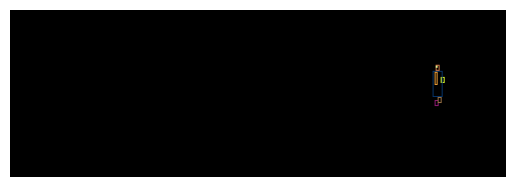

xa.s12.00.mhz.1970-03-25HR00_evid00003
13 217


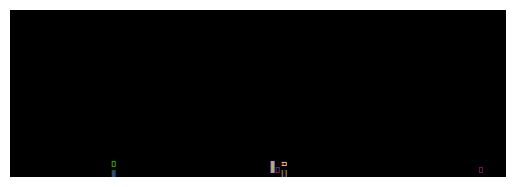

xa.s12.00.mhz.1970-03-26HR00_evid00004
13 188


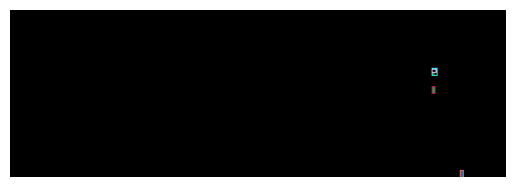

xa.s12.00.mhz.1970-04-25HR00_evid00006
13 210


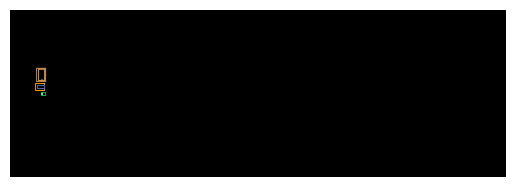

xa.s12.00.mhz.1970-04-26HR00_evid00007
13 214


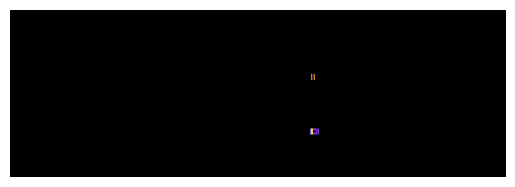

xa.s12.00.mhz.1970-06-15HR00_evid00008
13 215


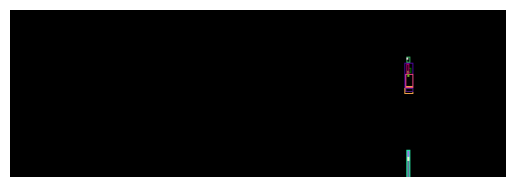

xa.s12.00.mhz.1970-06-26HR00_evid00009
13 200


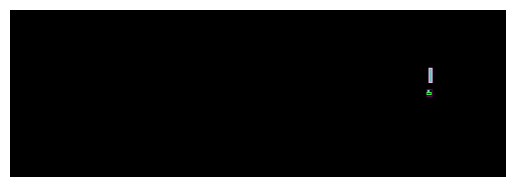

xa.s12.00.mhz.1970-07-20HR00_evid00010
13 202


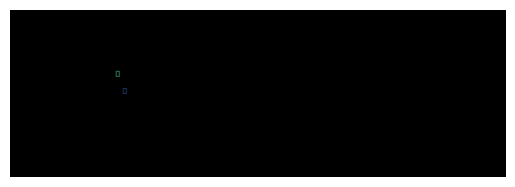

xa.s12.00.mhz.1970-07-20HR00_evid00011
13 202


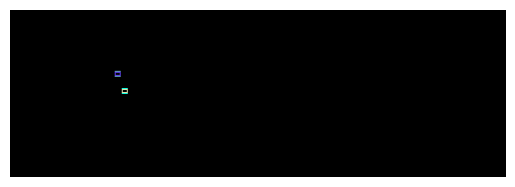

xa.s12.00.mhz.1970-09-26HR00_evid00013
13 200


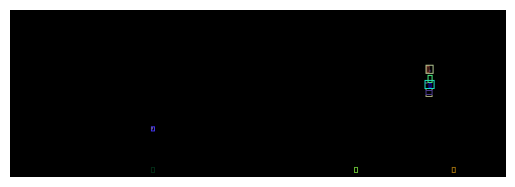

xa.s12.00.mhz.1970-10-24HR00_evid00014
13 204


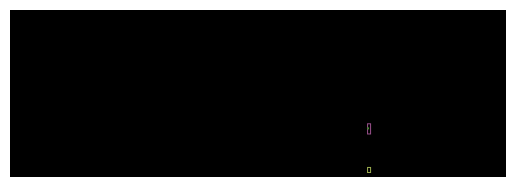

xa.s12.00.mhz.1970-11-12HR00_evid00015
13 90


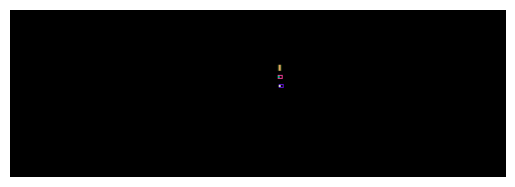

xa.s12.00.mhz.1970-12-11HR00_evid00017
13 164


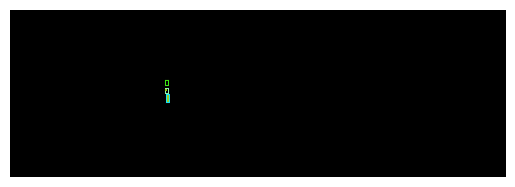

xa.s12.00.mhz.1970-12-27HR00_evid00019
13 211


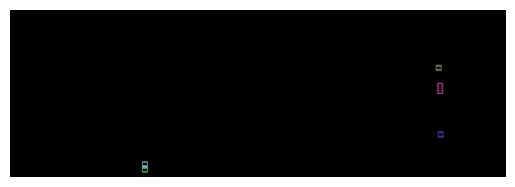

xa.s12.00.mhz.1970-12-31HR00_evid00021
13 29


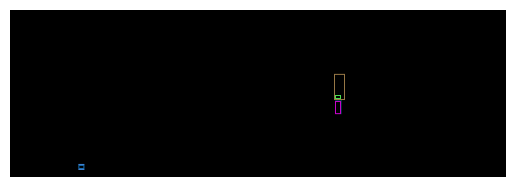

xa.s12.00.mhz.1971-01-15HR00_evid00022
13 214


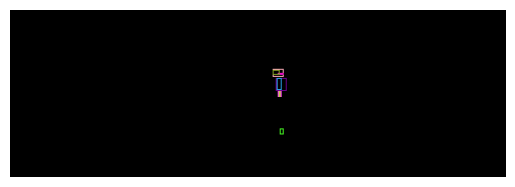

xa.s12.00.mhz.1971-01-28HR00_evid00023
13 184


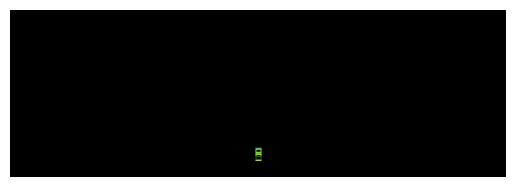

xa.s12.00.mhz.1971-01-29HR00_evid00024
13 198


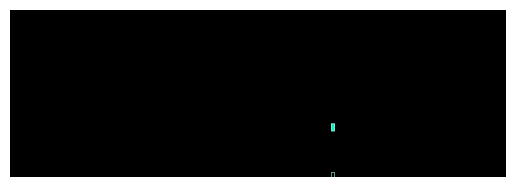

xa.s12.00.mhz.1971-02-09HR00_evid00026
13 121


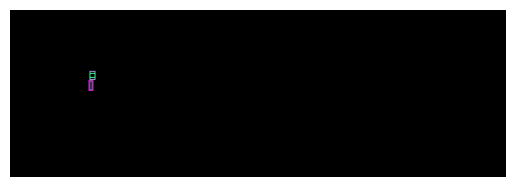

xa.s12.00.mhz.1971-03-25HR00_evid00028
13 211


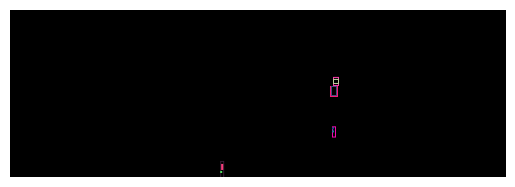

xa.s12.00.mhz.1971-04-13HR02_evid00029
13 215


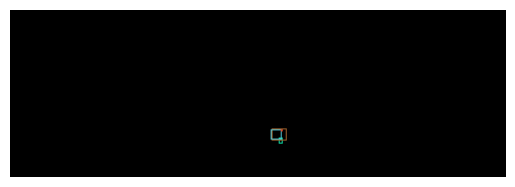

xa.s12.00.mhz.1971-04-17HR00_evid00030
13 210


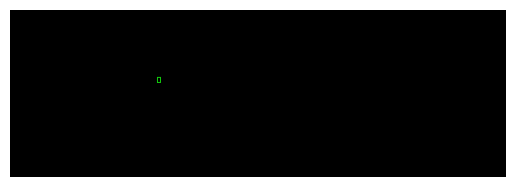

xa.s12.00.mhz.1971-05-12HR00_evid00031
13 187


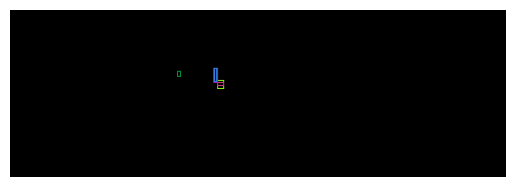

xa.s12.00.mhz.1971-05-12HR00_evid00032
13 187


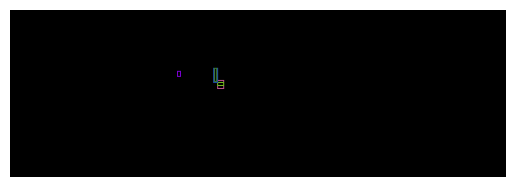

xa.s12.00.mhz.1971-05-13HR00_evid00033
13 218


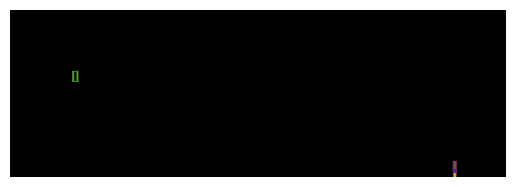

xa.s12.00.mhz.1971-05-23HR00_evid00034
13 218


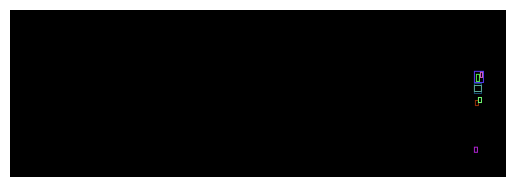

xa.s12.00.mhz.1971-06-12HR00_evid00035
13 211


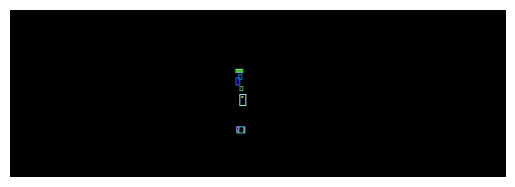

xa.s12.00.mhz.1971-09-25HR00_evid00042
13 185


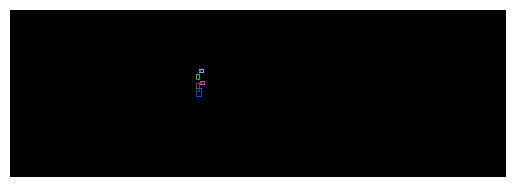

xa.s12.00.mhz.1971-10-18HR00_evid00043
13 17


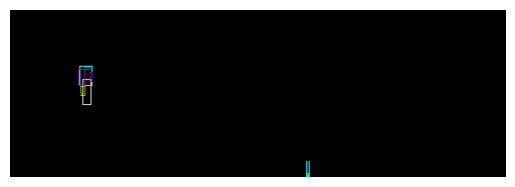

xa.s12.00.mhz.1971-10-20HR00_evid00044
13 206


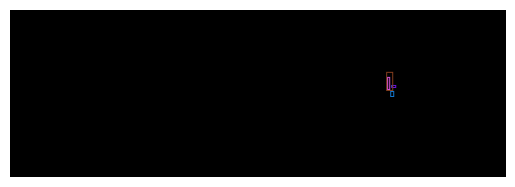

xa.s12.00.mhz.1971-10-31HR00_evid00045
13 217


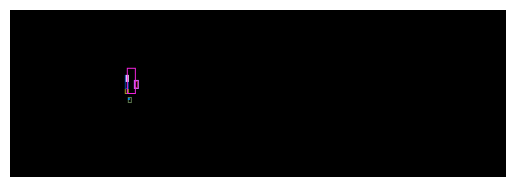

xa.s12.00.mhz.1971-11-14HR00_evid00046
13 215


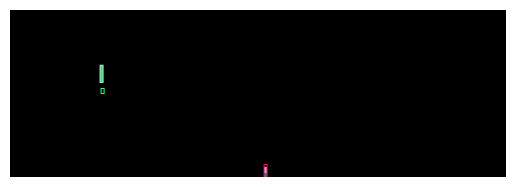

xa.s12.00.mhz.1972-01-04HR00_evid00049
13 39


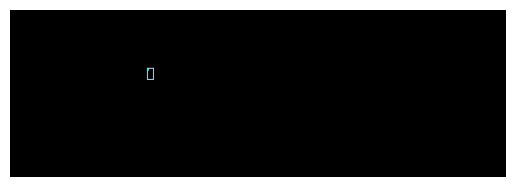

xa.s12.00.mhz.1972-03-12HR00_evid00052
13 202


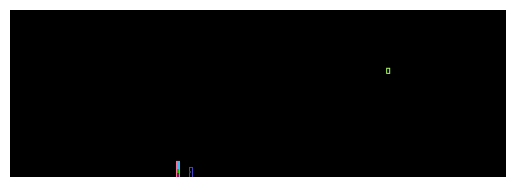

xa.s12.00.mhz.1972-05-11HR00_evid00055
13 57


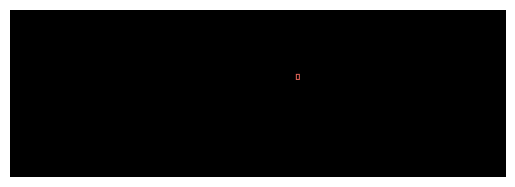

xa.s12.00.mhz.1972-06-16HR00_evid00060
13 205


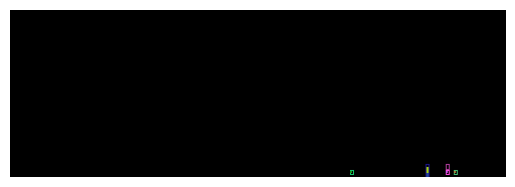

xa.s12.00.mhz.1972-07-17HR00_evid00067
13 188


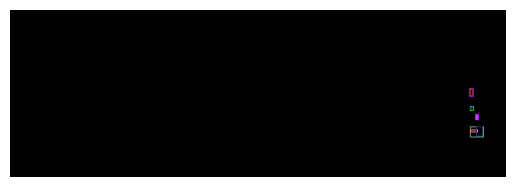

xa.s12.00.mhz.1972-07-17HR00_evid00068
13 188


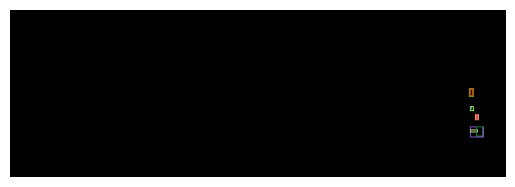

xa.s12.00.mhz.1972-07-28HR00_evid00070
13 195


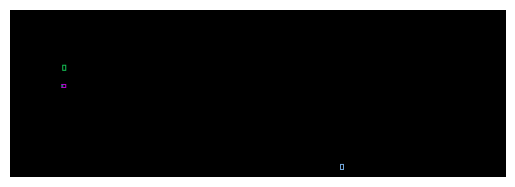

xa.s12.00.mhz.1972-07-31HR00_evid00071
13 214


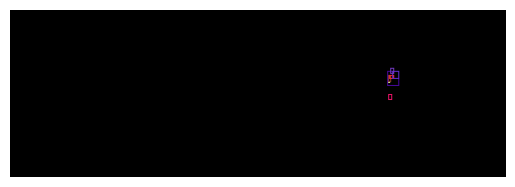

xa.s12.00.mhz.1972-12-02HR00_evid00083
13 83


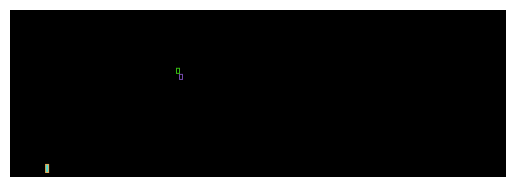

xa.s12.00.mhz.1972-12-03HR00_evid00084
13 212


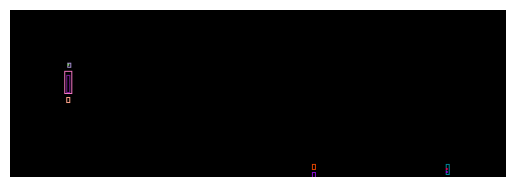

xa.s12.00.mhz.1973-01-18HR00_evid00088
13 217


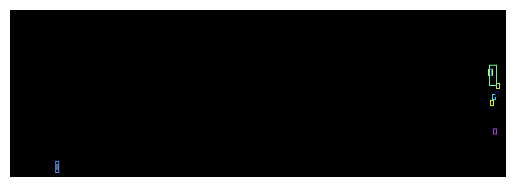

xa.s12.00.mhz.1973-01-31HR00_evid00091
13 135


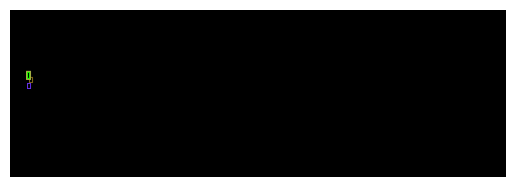

xa.s12.00.mhz.1973-03-01HR00_evid00093
13 146


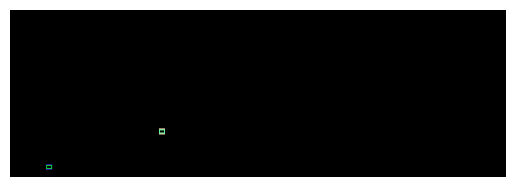

xa.s12.00.mhz.1973-03-13HR00_evid00094
13 160


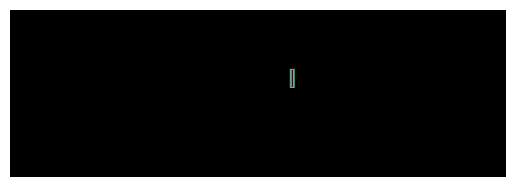

xa.s12.00.mhz.1973-03-24HR00_evid00097
13 217


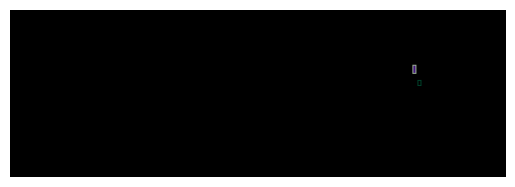

xa.s12.00.mhz.1973-05-14HR00_evid00104
13 118


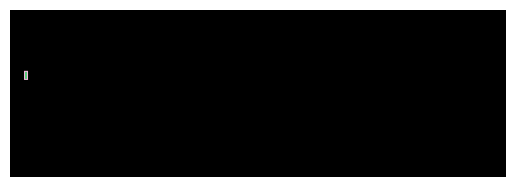

xa.s12.00.mhz.1973-06-05HR00_evid00107
13 202


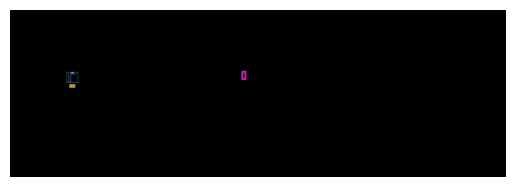

xa.s12.00.mhz.1973-06-05HR00_evid00108
13 202


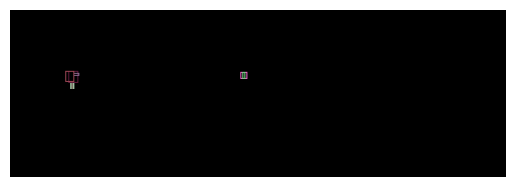

xa.s12.00.mhz.1973-06-18HR00_evid00109
13 100


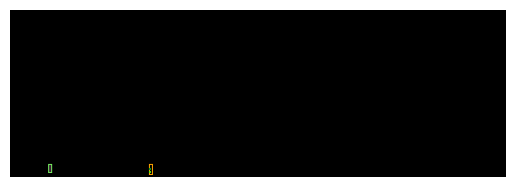

xa.s12.00.mhz.1973-06-27HR00_evid00112
13 184


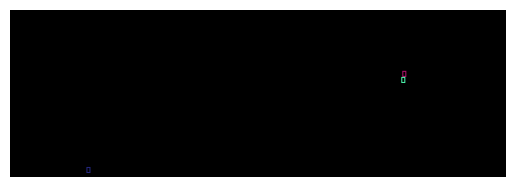

xa.s12.00.mhz.1973-07-03HR00_evid00113
13 211


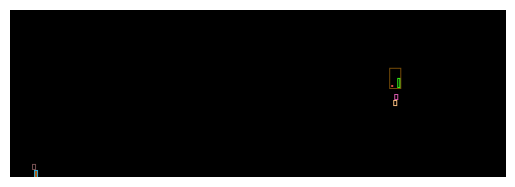

xa.s12.00.mhz.1973-07-04HR00_evid00114
13 216


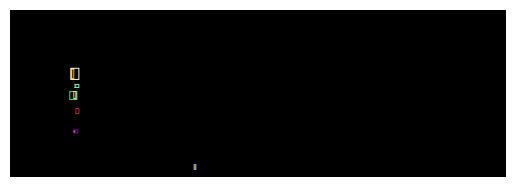

xa.s12.00.mhz.1973-07-20HR00_evid00117
13 162


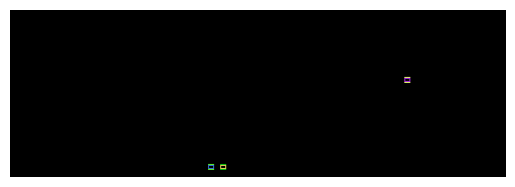

xa.s12.00.mhz.1973-07-28HR00_evid00120
13 213


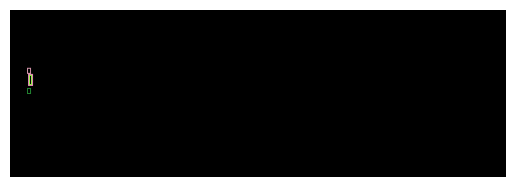

xa.s12.00.mhz.1973-07-29HR00_evid00121
13 140


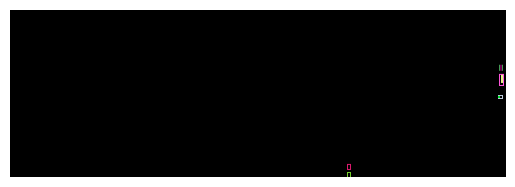

xa.s12.00.mhz.1973-08-21HR00_evid00127
13 184


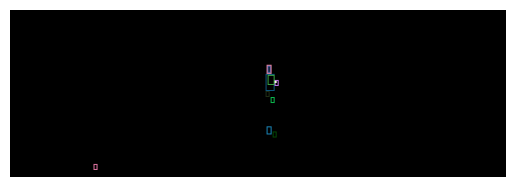

xa.s12.00.mhz.1974-01-10HR00_evid00136
13 204


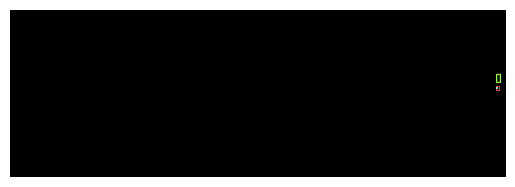

xa.s12.00.mhz.1974-02-07HR00_evid00137
13 183


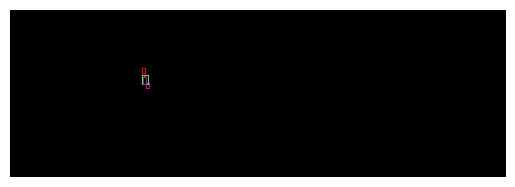

xa.s12.00.mhz.1974-02-12HR00_evid00138
13 199


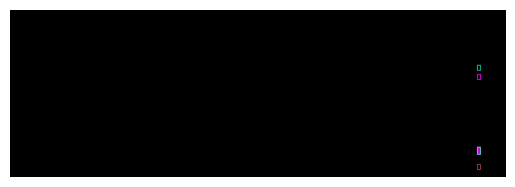

xa.s12.00.mhz.1974-03-25HR00_evid00140
13 90


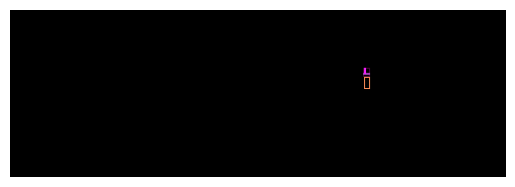

xa.s12.00.mhz.1974-04-08HR00_evid00141
13 114


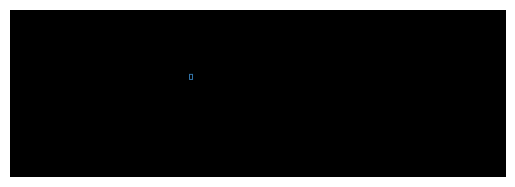

xa.s12.00.mhz.1974-04-19HR00_evid00142
13 121


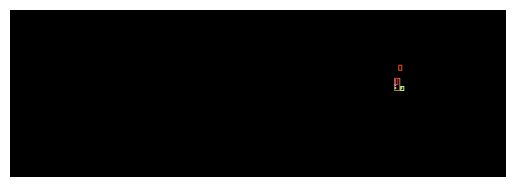

xa.s12.00.mhz.1974-04-26HR00_evid00144
13 217


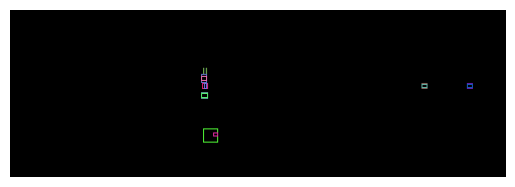

xa.s12.00.mhz.1974-04-27HR00_evid00145
13 208


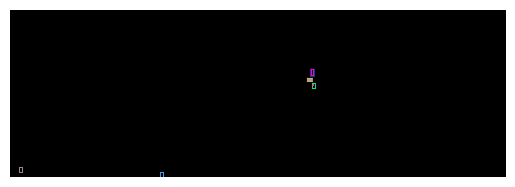

xa.s12.00.mhz.1974-06-25HR00_evid00149
13 83


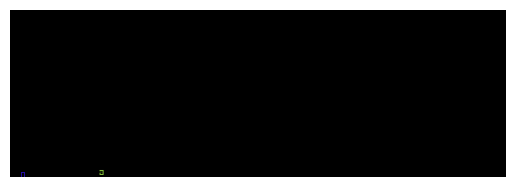

xa.s12.00.mhz.1974-07-06HR00_evid00150
13 214


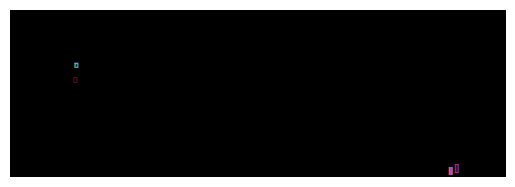

xa.s12.00.mhz.1974-07-06HR00_evid00151
13 214


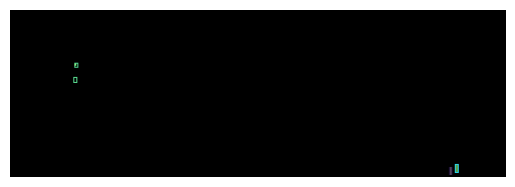

xa.s12.00.mhz.1974-07-11HR00_evid00152
13 201


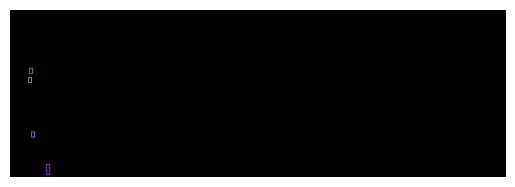

xa.s12.00.mhz.1974-07-17HR00_evid00153
13 212


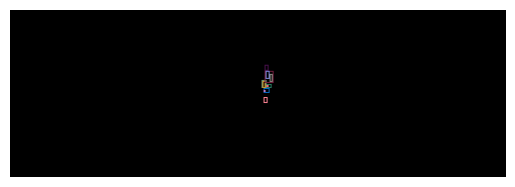

xa.s12.00.mhz.1974-10-14HR00_evid00156
13 194


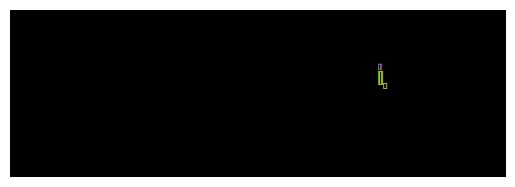

xa.s12.00.mhz.1975-04-12HR00_evid00191
13 164


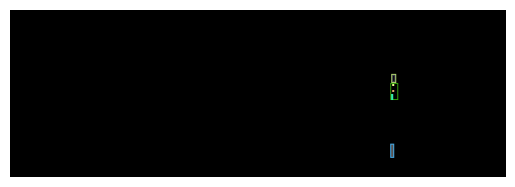

xa.s12.00.mhz.1975-05-04HR00_evid00192
13 221


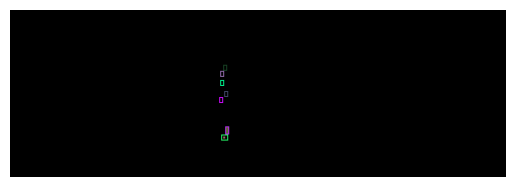

xa.s12.00.mhz.1975-06-24HR00_evid00196
13 184


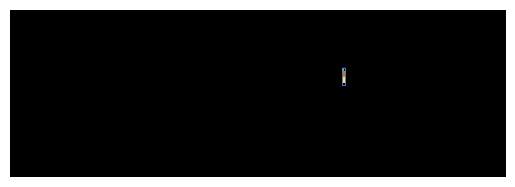

xa.s12.00.mhz.1975-06-26HR00_evid00198
13 40


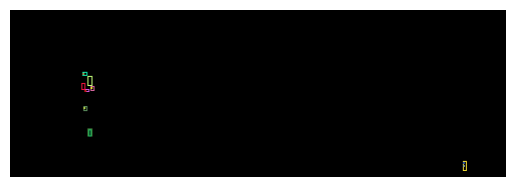

In [111]:
path_c_moon = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
moon_catalog_sub = detect_arrival_end_catalog(path_c_moon, type= 'lunar', sh = True)

Se calculan las diferencias entre los arrivals detectados y los reales.

In [113]:
moon_catalog_sub['Diferencia'] = abs(moon_catalog_sub['time_rel(sec)']-moon_catalog_sub['arrival_img'])

In [114]:
#Descomentar estas secciones si se quiere ver el df entero.

#pd.set_option('display.max_rows', None)  # Mostrar todas las filas
#pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
moon_catalog_sub['Ventana'] = moon_catalog_sub['end_img'] - moon_catalog_sub['arrival_img']


In [115]:
moon_catalog_sub['Diferencia_tasa'] = 100 - moon_catalog_sub['Ventana']*100 / 600000

In [116]:
moon_catalog_sub['Ahorro'] = 1 - (moon_catalog_sub['Ventana'] / moon_catalog_sub['len_time'])

Se obtiene el ahorro de datos promedio

In [117]:
ahorro_prom = np.mean(moon_catalog_sub['Ahorro'])
ahorro_prom

0.7903277463435466

In [138]:
moon_catalog_sub

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type,arrival_img,end_img,len_time,Diferencia,Ventana,Diferencia_tasa,Ahorro
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq,73608.291171,75536.127368,86402.113208,108.291171,1927.836197,99.678694,0.977688
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq,17700.917754,82195.350760,86401.509434,4980.917754,64494.433005,89.250928,0.253550
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq,73432.520188,78865.475143,86401.509434,412.520188,5432.954954,99.094508,0.937120
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq,4381.445903,6134.024264,86402.113208,58.554097,1752.578361,99.707904,0.979716
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq,52226.470206,53628.523097,86401.509434,86.470206,1402.052891,99.766325,0.983773
...,...,...,...,...,...,...,...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq,64144.704198,65546.774236,86402.566038,364.704198,1402.070037,99.766322,0.983773
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq,66248.387921,67475.209920,86403.320755,548.387921,1226.821999,99.795530,0.985801
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq,36453.820965,38031.149757,86402.566038,153.820965,1577.328792,99.737112,0.981744
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq,57834.681771,58360.451605,86401.509434,54.681771,525.769834,99.912372,0.993915


Se obtiene el promedio de las diferencias para ver el promedio de error en arrivals.

In [139]:
mean = np.mean(moon_catalog_sub['Diferencia'])
mean

10433.811272411578

Vemos la distribución de las diferencias para ver las arrivals detectadas muy mal

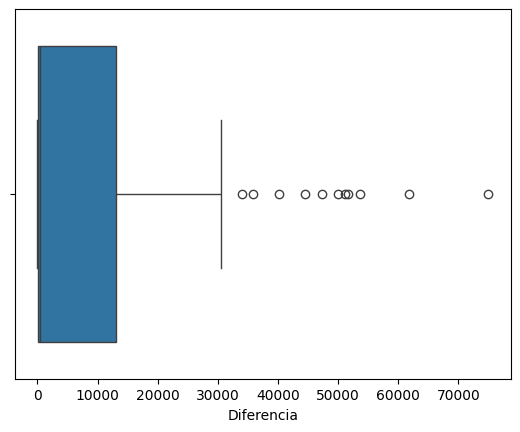

In [120]:
sns.boxplot(moon_catalog_sub, x='Diferencia')
q1 = moon_catalog_sub['Diferencia'].quantile(q = 0.25)
q3 = moon_catalog_sub['Diferencia'].quantile(q = 0.75)
ric = q3 - q1
lower_bound = q1 - 1.5 * ric
upper_bound = q3 + 1.5 * ric    

<Axes: xlabel='Ahorro', ylabel='Count'>

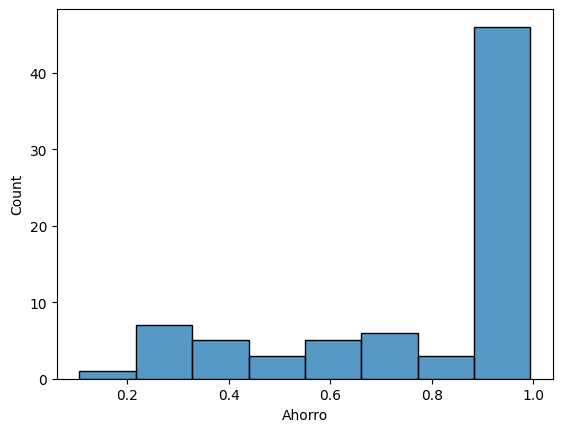

In [121]:
sns.histplot(moon_catalog_sub, x='Ahorro')  

In [122]:
np.median(moon_catalog_sub['Ahorro'])

0.973630831643002

<Axes: xlabel='Ahorro', ylabel='Count'>

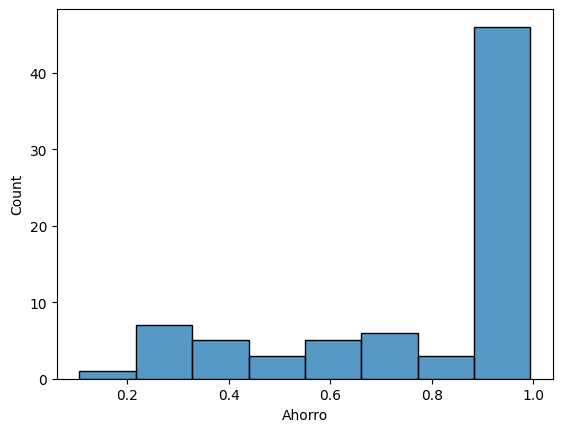

In [123]:
sns.histplot(moon_catalog_sub['Ahorro'])

## Detecciones vs tiempos reales

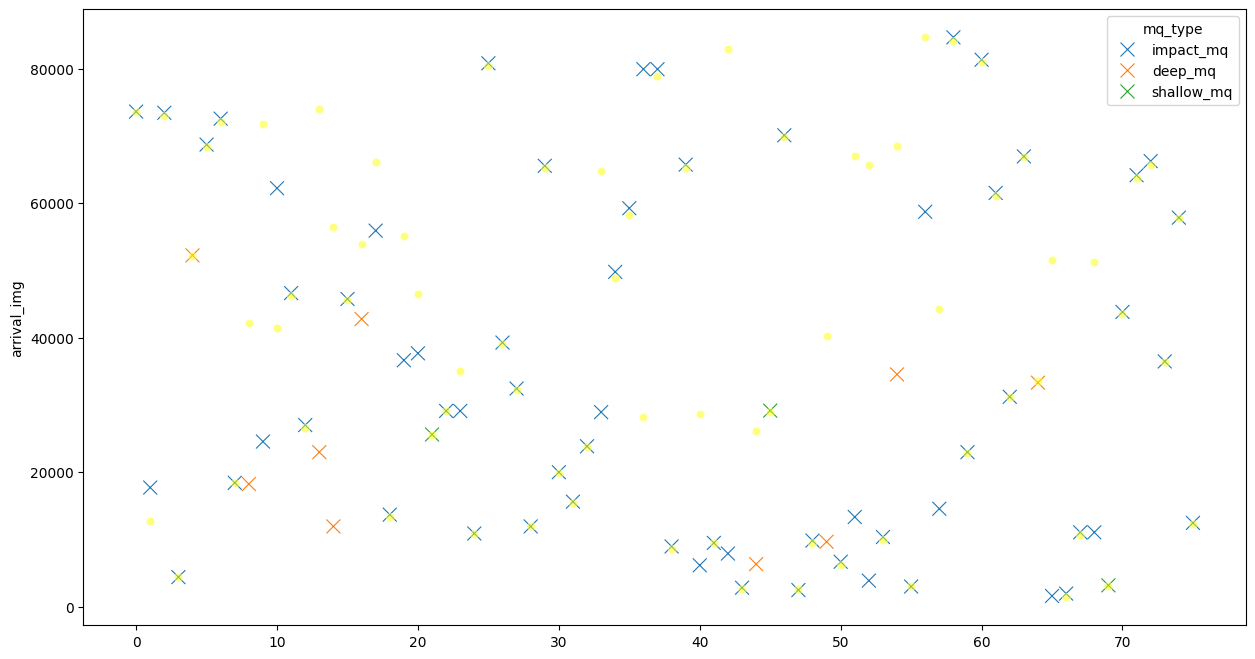

In [124]:
plt.figure(figsize=(15, 8))

# Primer scatterplot con 'x' y hue basado en mq_type
sns.scatterplot(x=range(len(moon_catalog_sub['arrival_img'])), 
                y=moon_catalog_sub['arrival_img'], 
                hue=moon_catalog_sub['mq_type'],
                marker='x', 
                s=100,  # tamaño de los puntos
                legend='full'  # muestra leyenda completa
                )

moon_catalog_sub['time_rel(sec)']
# Segundo scatterplot para destacar todos los puntos en amarillo
sns.scatterplot(x=range(len(moon_catalog_sub['time_rel(sec)'])), 
                y=moon_catalog_sub['time_rel(sec)'], 
                color='yellow', 
                alpha=0.5,  # añade transparencia para ver los puntos debajo
                legend=False  # no mostrar leyenda
                )

plt.show()



Filtramos los datos que se consideran atípicos (muy mal detectados)

In [125]:
q1 = moon_catalog_sub['Diferencia'].quantile(q = 0.25)
q3 = moon_catalog_sub['Diferencia'].quantile(q = 0.75)
ric = q3 - q1
lower_bound = q1 - 1.5 * ric
upper_bound = q3 + 1.5 * ric  

In [126]:
moon_catalog_sub_filtred = moon_catalog_sub[(moon_catalog_sub['Diferencia'] >= lower_bound) & (moon_catalog_sub['Diferencia'] <= upper_bound)]

Observamos la cantidad y proporcion de arrivals muy mal detectados

In [127]:
cant_mal_marcados = len(moon_catalog_sub) - len(moon_catalog_sub_filtred)
cant_mal_marcados

11

Obtenemos un promedio de diferencia sin tener en cuenta los arrivals muy mal detectados

In [128]:
promedio_sin_atipicos = np.mean(moon_catalog_sub_filtred['Diferencia'])
promedio_sin_atipicos

3813.996553196124

In [140]:
promedio_ahorro_sin_atipicos = np.mean(moon_catalog_sub_filtred['Ahorro'])
promedio_ahorro_sin_atipicos

0.8513028553596506

In [142]:
median_ahorro_sin_atipicos = np.median(moon_catalog_sub_filtred['Ahorro'])
median_ahorro_sin_atipicos

0.9797160243407708

## Deteccion arrival y end para mars train

In [129]:
mars_ex = read('./data/mars/training/data/XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed')

In [130]:
mars_ex[0]

XB.ELYSE.02.BHV | 2022-01-02T04:00:00.025000Z - 2022-01-02T04:59:59.975000Z | 20.0 Hz, 72000 samples

In [131]:
image, len_t = imagen(mars_ex[0])

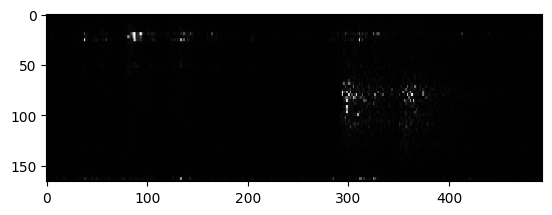

(<Figure size 640x480 with 1 Axes>,
 None)

In [132]:
plt.figure(),plt.imshow(image, cmap = 'gray'), plt.show()

13 215


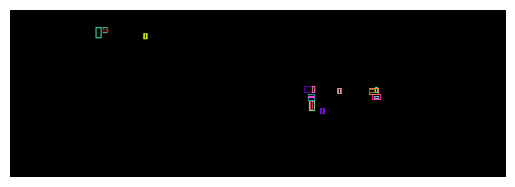

(85, 368)

In [133]:
detect(image, type_mq='mars', sh = True)

In [134]:
mars_c_path = './data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv'

mars_c_sub = detect_arrival_end_catalog(mars_c_path, type= 'mars')

XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv
13 188
XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv
13 215


In [135]:
mars_c_sub['Diferencia'] = abs(mars_c_sub['time_rel(sec)'] - mars_c_sub['end_img'])

In [136]:
mars_c_sub

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,arrival_img,end_img,len_time,Diferencia
0,XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.csv,2022-02-03T08:08:27.000000,507.0,evid0005,693.702333,715.608722,3599.95,208.608722
1,XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv,2022-01-02T04:35:30.000000,2130.0,evid0006,620.681034,2687.183773,3599.95,557.183773


In [137]:
np.mean(mars_c_sub['Diferencia'])

382.8962474645029